## Partie I: Preparation des données (preprocessing)

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from io import BytesIO #permet de stocker en mémoire
from zipfile import ZipFile

url2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip" #enquete 2019
url2020="https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip" #enquête 2020 en exemple

# Télécharge le fichier ZIP
requete = requests.get(url2019)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2019 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Télécharge le fichier ZIP
requete = requests.get(url2020)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2020 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

In [2]:
# On choisit un set de features qui ne comprend que données sociodémographiques, géographiques associées à l'individu
# et au ménage étudié + qui sont disponibles sur les deux années étudiées

# label -> ACTEU

# features à inclure dans le modèle -> AGE3 ;  AGE5 ; ANNEE ;TRIM ;  CATAU2010R ; COURED ; CSTOT (pour avoir actifs et inactifs) ;CSTOTR ;
# CSTOTPRM ; DIP11; ENFRED ; METRODOM ; NFRRED ; SEXE ; TYPMEN7 

# USE? -> AIDFAM , CHPUB?? (Employeur de la profession principale?), EXTRIAN? (pondération)

# Meme si les variables sont colinéaires (AGE3, AGE5), on peut les garder et faire en sorte que le predicteur
# choisisse la plus pertinente

# Je pense que le problème principal vient du fait qu'on a en fait trop peu de variable, et donc rien qui ne puisse être vraiment pertinent en fait
#c'est pour cela que les algorithmes ne trouvent rien je pense.

list_var_selected = ["ACTEU","ANNEE" ,"TRIM", "AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"]

EEC_2019 = EEC_2019[list_var_selected]
EEC_2020 = EEC_2020[list_var_selected]

list_var = list(EEC_2019.columns.values)
print(list_var)

#je regarde ce qu'il se passe si je ne sépare pas les trimestres, le prof avait l'air de dire que c'était pas forcément grave (Alexis)
#EEC_2019 = EEC_2019[EEC_2019['TRIM'] ==1]
#EEC_2020 = EEC_2020[EEC_2020['TRIM'] ==4]

# Il y a très peu de valeurs manquantes dans les variables ->  dropna() drops any row that contains at least one missing value
# On aurait aussi pu faire de l'imputation
print(EEC_2019.shape)
EEC_2019 = EEC_2019.dropna() 
EEC_2020 = EEC_2020.dropna() 
print(EEC_2019.shape)

# Converti l'ensemble des variables catégorielles en dummies
# Oui oui faut le faire, par contre pour les variables qui sont DEJA des dummies, c'est pas la peine, faut juste les recoder en 0 et 1
EEC_2019 = pd.get_dummies(EEC_2019, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11", "NFRRED" , "TYPMEN7"])
EEC_2020 = pd.get_dummies(EEC_2020, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11", "NFRRED" , "TYPMEN7"])

#RECODAGE variables binaires (dummies)

EEC_2019['EMPLOI'] = EEC_2019['ACTEU'].apply(lambda x: x == 1)
EEC_2020['EMPLOI'] = EEC_2020['ACTEU'].apply(lambda x: x == 1)

EEC_2019['ACTIF'] = EEC_2019['ACTEU'].apply(lambda x: (x == 1) or (x == 2))
EEC_2020['ACTIF'] = EEC_2020['ACTEU'].apply(lambda x: (x == 1) or (x == 2))

EEC_2019['FEMME'] = EEC_2019['SEXE'].apply(lambda x: x == 2)
EEC_2020['FEMME'] = EEC_2020['SEXE'].apply(lambda x: x == 2)

EEC_2019['COUPLE'] = EEC_2019['COURED'].apply(lambda x: x == 2)
EEC_2020['COUPLE'] = EEC_2020['COURED'].apply(lambda x: x == 2)

EEC_2019['ENFANT'] = EEC_2019['ENFRED'].apply(lambda x: x == 2)
EEC_2020['ENFANT'] = EEC_2020['ENFRED'].apply(lambda x: x == 2)


EEC_2019['DOM'] = EEC_2019['METRODOM'].apply(lambda x: x == 2)
EEC_2020['DOM'] = EEC_2020['METRODOM'].apply(lambda x: x == 2)

#Vire les anciennes
EEC_2019 = EEC_2019.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)
EEC_2020 = EEC_2020.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)

# 134 variables
print(EEC_2019.shape)

# Gestion des outliers??? Pas nécessaire ici puisqu'on fonctionne seulement avec des variables catégorielles

# standardisation des variables explicatives ? Pas utile car que des dummies
# (La standardisation permet une convergence plus rapide des algorithmes pour des variables réelles)

EEC_2019_subsample = EEC_2019.sample(n=10000, random_state=3) 


['ACTEU', 'ANNEE', 'TRIM', 'AGE3', 'AGE5', 'CATAU2010R', 'COURED', 'CSTOT', 'CSTOTR', 'CSTOTPRM', 'DIP11', 'ENFRED', 'METRODOM', 'NFRRED', 'SEXE', 'TYPMEN7']
(416298, 16)
(412028, 16)
(412028, 134)


In [3]:
# Balanced sample avec prediction emploi
proportion_values = EEC_2019_subsample['EMPLOI'].value_counts(normalize=True)
print(proportion_values)

EMPLOI
False    0.5292
True     0.4708
Name: proportion, dtype: float64


In [4]:
# Description d'une feature pour check booléen
variable_description = EEC_2019_subsample["FEMME"].describe()

print(variable_description)

count     10000
unique        2
top        True
freq       5188
Name: FEMME, dtype: object


In [5]:
# On transforme nos dataframes en array car sklearn est bien adapté pour travailler sur ce type de données

# Array contentant l'ensemble des variables explicatives (on exclut donc CHOMAGE/ANNEE/TRIM)
X = np.array(EEC_2019_subsample.drop(columns=["ACTIF","EMPLOI","ANNEE", "TRIM"]))
print(X.shape)

# Array contentant la variable expliquée
y = np.array(EEC_2019_subsample["EMPLOI"])
print(y.shape)


print(X[:10])
print(y[:10])


(10000, 130)
(10000,)
[[False False  True ...  True  True False]
 [False False  True ... False  True False]
 [False False  True ... False False False]
 ...
 [False False  True ... False  True False]
 [False False  True ... False  True  True]
 [False False  True ...  True  True False]]
[False False  True False False False False False False False]


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, random_state=3)

## Partie II : Support Vector Machine

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = SVC( C=param, random_state=3)
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))


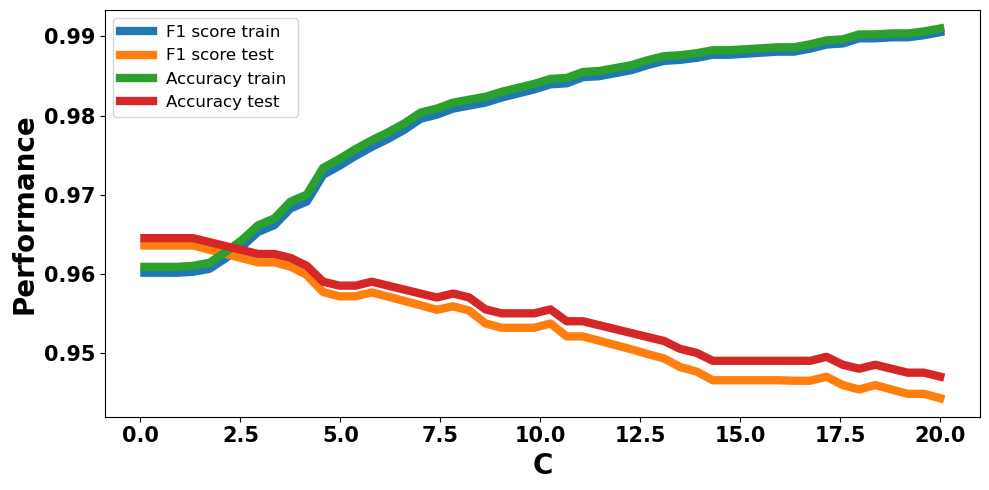

In [8]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


In [9]:
from sklearn.model_selection import GridSearchCV

params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=SVC( C=params, random_state=3), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

#Calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'C': 0.1030204081632653}
0.960875
0.9645


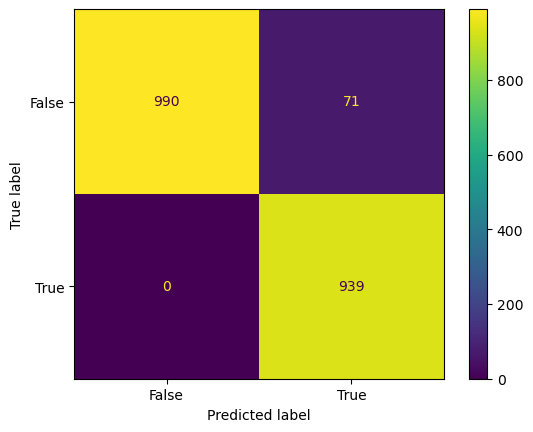

In [10]:
clf = SVC( C=gs.best_params_['C'], random_state=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [11]:
misclassified_indices = np.where(y_test != y_pred)[0]

# XX personnes préditent comme des actifs occupés alors qu'ils sont inactifs/chomeurs
# 0 personnes préditent pas actif occupés alors qu'ils le sont
print(y_test[misclassified_indices])

# ATTENTION -> Regarder si ils sont chomeurs ou inactifs?

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]


In [15]:
print(misclassified_indices.shape)
print(misclassified_indices)

(71,)
[  39  113  121  219  224  226  240  256  265  280  332  347  415  429
  451  458  467  472  497  504  536  550  565  575  578  623  670  694
  698  706  808  826  843  863  894  909  931  960  968  975  989 1031
 1038 1118 1132 1163 1198 1246 1262 1277 1283 1449 1483 1517 1532 1552
 1562 1577 1582 1605 1608 1627 1661 1693 1714 1776 1847 1867 1931 1947
 1994]


## Partie III - Regression logistique

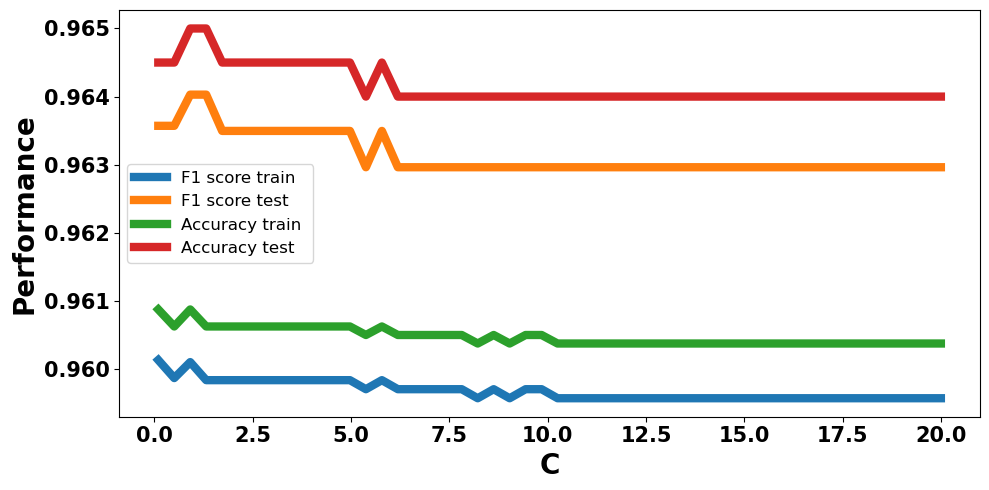

In [16]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

                        
C_range = np.linspace(0.1, 20, 50)

for param in C_range:
    clf = LogisticRegression(C=param,random_state=3, penalty="l1",solver='liblinear' )
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))
    
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


In [17]:
# Processus de cross-validation qui découpe notre échantillon en 5 et détermine le paramètre de régularisation optimal
# ATTENTION -> gain de selection des paramètres via cross validation est marginal par rapport à la selection des bonnes variables 
# On utilise GridSearch ici parce qu'on veut combiner plusieurs paramètres

#  By default, scikit-learn's GridSearchCV does not select the most parsimonious model (fewer features)
# when multiple models have equal scores. GridSearchCV uses the mean cross-validated score to select
# the best model based on the specified scoring metric.
# If there are multiple models with the same highest mean score, GridSearchCV selects
# the one with the smallest value of the parameters.

# If we want to select the most parsimonious model among those with equal scores,
# you may need to implement a custom scoring function

params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

results_df = pd.DataFrame(gs.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score']])

                       params  mean_test_score  std_test_score
0                {'C': 0.001}         0.528875        0.000250
1   {'C': 0.1030204081632653}         0.960875        0.002550
2   {'C': 0.2050408163265306}         0.960875        0.002550
3   {'C': 0.3070612244897959}         0.960750        0.002417
4   {'C': 0.4090816326530612}         0.960625        0.002305
5   {'C': 0.5111020408163265}         0.960625        0.002305
6   {'C': 0.6131224489795918}         0.960250        0.002756
7   {'C': 0.7151428571428571}         0.960250        0.002756
8   {'C': 0.8171632653061224}         0.960000        0.003236
9   {'C': 0.9191836734693877}         0.959875        0.003478
10  {'C': 1.0212040816326529}         0.959875        0.003478
11   {'C': 1.123224489795918}         0.959875        0.003478
12  {'C': 1.2252448979591835}         0.959875        0.003478
13  {'C': 1.3272653061224489}         0.959875        0.003478
14   {'C': 1.429285714285714}         0.959875        0

In [18]:
# On refait meme process en jouant en + sur le critère de penalty et le tol
# tol = tolerance for stopping criteria. It defines the stopping criterion for the solver to converge to a solution.

params= { 'C':np.linspace(0.001, 5, 50),'tol': [0.01, 0.1, 1, 10] }


gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

# calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'C': 0.1030204081632653, 'tol': 0.01}
0.960875
0.9645


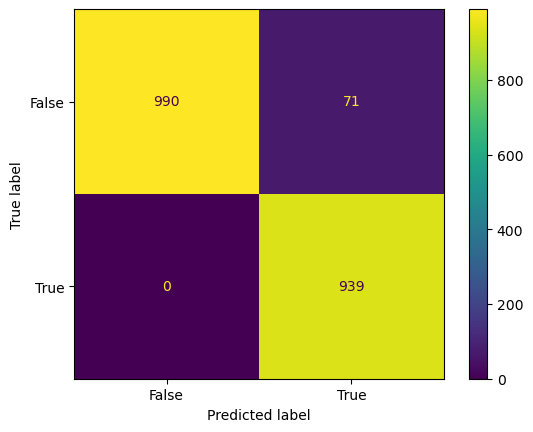

In [19]:
clf = LogisticRegression( tol=gs.best_params_['tol'], C=gs.best_params_['C'], random_state=3,
                         penalty ="l1", solver='liblinear')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [20]:
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

Number of variables considered: 21


## Partie IV : Selections de variables

In [21]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y)

# Je m'impose un maximum de 10 features selectionnées
sfm = SelectFromModel(clf, prefit=True, max_features=10)

# X transform contient un nombre réduit de caractéristiques basé sur la sélection
# des caractéristiques par régression Lasso.

sfm.fit(X,y)
X_transform = sfm.transform(X)
print("Transformed data shape:", X_transform.shape)
print("Original data shape:", X.shape)

Transformed data shape: (10000, 10)
Original data shape: (10000, 130)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform, 
                                                    y, 
                                                    test_size=.2, random_state=3)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }



gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

print(gs.best_params_)
print(gs.score(X_train_2, y_train_2))
print(gs.score(X_test_2, y_test_2))

{'C': 0.021387755102040818, 'tol': 0.01}
0.960875
0.9645


Number of variables considered: 3
[[ 0.          0.          0.          0.          0.          0.
  -6.14109911 -5.1221531   0.         -0.27148709]]


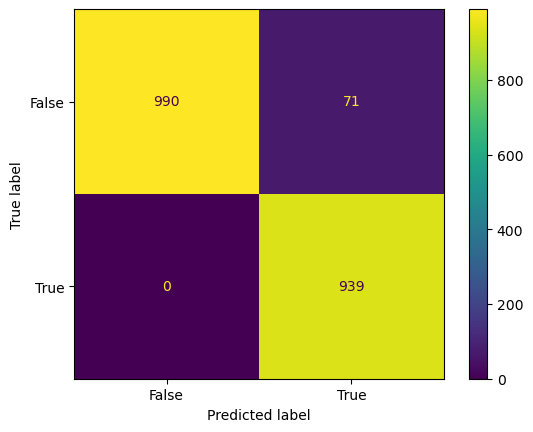

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

num_variables = np.sum(np.abs(clf.coef_) > 0)
print("Number of variables considered:", num_variables)

#On obtient la meme matrice en utilisant ici que 3 variables explicatives

print(clf.coef_)

In [26]:
variables_indices = np.where(np.abs(clf.coef_) > 1e-10)[1]
variables = EEC_2019_subsample.drop(columns=["EMPLOI", "ANNEE", "TRIM"]).columns[variables_indices].values
print(variables_indices)
print(variables)

# predicteur efficace avec 3 variables : avoir la cinquantaine, la soixantaine, lieu d'habitation

[6 7 9]
['AGE5_50' 'AGE5_60' 'CATAU2010R_2']


In [95]:
# J'essaie de reconstruire la variable predite à partir des 3 variables et des coefs associés
linear_pred_3 = clf.intercept_ + np.dot(X_test_2[:, variables_indices], clf.coef_[:, variables_indices].T) 
y_pred_3 = 1 / (1 + np.exp(-linear_pred_3))
threshold = 0.5  # Adjust the threshold as needed
y_pred_3_binary = (y_pred_3 > threshold).astype(bool).ravel()

comparison = np.equal(y_pred_2, y_pred_3_binary)
equal_predictions = np.sum(comparison)
percentage_equal = (equal_predictions / len(y_pred_2)) * 100 
print("% same predictor",percentage_equal)

[ True False False ... False  True False]
[ True False False ... False  True False]
% same predictor 100.0


## Partie V : Compréhension du problème de prédiction

Je pense que les problèmes de prédiction proviennent des chômeurs de courte durée qui ont donc des caractéristiques très similaires aux actifs de ma base, et sont donc prédits comme tels. Pour vérifier cela, je vais maintenant étudier la prédiction du fait d'être actif pour voir si nous parvenons à construire un meilleur prédicteur.





In [27]:
# Array contentant la variable expliquée
y_bis = np.array(EEC_2019_subsample["ACTIF"])
print(y_bis.shape)

print(y_bis[:10])

(10000,)
[False False  True False False False False False False False]


(10000,)


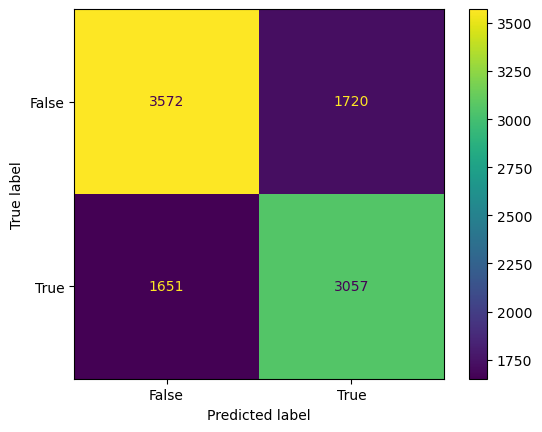

In [28]:
#avant de regarder pour actif, regardons peut-être pour emploi, sur lequel on s'attends à ce que cela fonctionne

y_ter = np.array(EEC_2019_subsample["EMPLOI"])
print(y_ter.shape)


linear_pred_3 = clf.intercept_ + np.dot(X[:, variables_indices], clf.coef_[:, variables_indices].T) 
y_pred_3 = 1 / (1 + np.exp(-linear_pred_3))
threshold = 0.5  # Adjust the threshold as needed
y_pred_3_binary = (y_pred_3 > threshold).astype(bool).ravel()

cm= confusion_matrix(y_ter,y_pred_3_binary)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

#et manifestement, ça ne fonctionne pas du tout. Ma théorie c'est que le problème vient de y_pred_3. En tous cas il y a un problème ici.

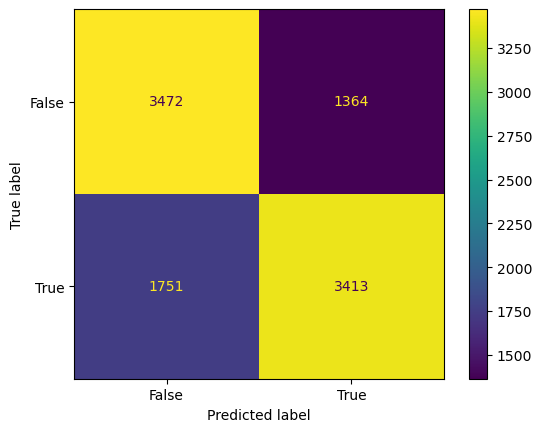

In [29]:
linear_pred_3 = clf.intercept_ + np.dot(X[:, variables_indices], clf.coef_[:, variables_indices].T) 
y_pred_3 = 1 / (1 + np.exp(-linear_pred_3))
threshold = 0.5  # Adjust the threshold as needed
y_pred_3_binary = (y_pred_3 > threshold).astype(bool).ravel()

cm= confusion_matrix(y_bis,y_pred_3_binary)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

# Prédicteur de l'emploi ne fonctionne pas bien pour prédire actif/pas actif => logique (ouais enfin à ce point...)

(10000, 5)
[[-0.46360546  3.85990272 -0.85050148 -9.16622493 -7.27332228]]
Number of variables considered: 5
['AGE3_15' 'AGE3_30' 'AGE3_50' 'AGE5_15' 'AGE5_30']


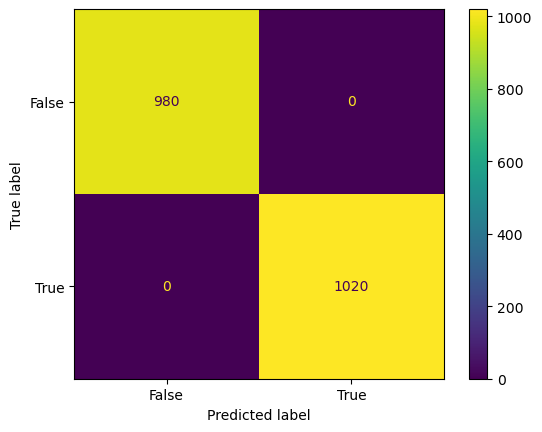

In [60]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y_bis)

# Je m'impose un maximum de 10 features selectionnées
sfm = SelectFromModel(clf, prefit=True, max_features=10) #il y avait une coquille ici, le max indiqué était 3, et pas 10. Du coup il en garde 5 (pouruoi alors qu'il était parfait avec 3, ça ...)

sfm.fit(X,y_bis)

X_transform_bis = sfm.transform(X)
print(X_transform_bis.shape)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform_bis, 
                                                    y_bis, 
                                                    test_size=.2, random_state=3)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }

gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)


cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

print(clf.coef_)
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

variables_indices = np.where(np.abs(clf.coef_) > 1e-10)[1]
variables = EEC_2019_subsample.drop(columns=["ACTIF","EMPLOI", "ANNEE", "TRIM"]).columns[variables_indices].values
print(variables)

# Effectivement avec 3 variables (qui ne sont pas les meme), le modèle arrive à prédire parfaitement le fait d'être actif
# ou de ne pas l'être sur l'échantillon test

In [51]:
print(y_test_2)
print(y_pred_2)

[ True False False ... False  True False]
[ True False False ... False  True False]


Il semblerait que le problème vienne effectivement de la distinction qui peut être parfois difficile à faire entre les chomeurs et les actifs occupés

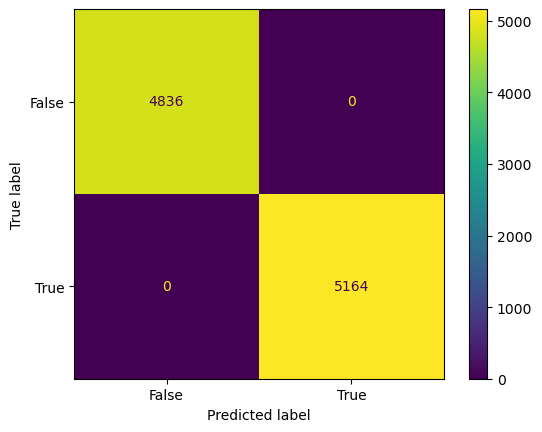

In [63]:
y_pred_4 = clf.predict(X_transform_bis)


cm= confusion_matrix(y_bis,y_pred_4)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

# Predicteur "clf" permet une prediction parfaite sur notre echantillon X à partir de 3 variables ! Etonnant?!

(315964, 5)


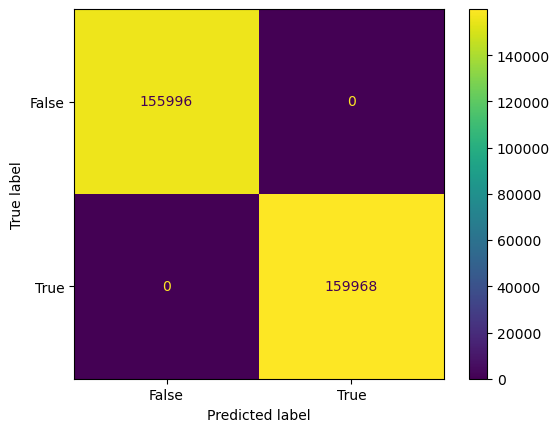

In [64]:
X_2020 = np.array(EEC_2020.drop(columns=["ACTIF","EMPLOI","ANNEE", "TRIM"]))
y_2020 = np.array(EEC_2020["ACTIF"])

X_2020_transform = sfm.transform(X_2020)
print(X_2020_transform.shape)

y_pred_2020 = clf.predict(X_2020_transform)


cm= confusion_matrix(y_2020,y_pred_2020)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

# Prediction parfaite sur l'echantillon 2020 également !!


In [70]:
X_2020_transform

array([[ True, False, False,  True, False],
       [ True, False, False, False, False],
       [ True, False, False,  True, False],
       ...,
       [False, False, False, False,  True],
       [False, False, False, False, False],
       [False, False, False, False,  True]])

In [39]:
X_2020

array([[False, False,  True, ...,  True,  True, False],
       [False, False,  True, ..., False,  True, False],
       [False, False,  True, ..., False,  True, False],
       ...,
       [False,  True, False, ..., False, False,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False,  True, False, ...,  True, False,  True]])

In [42]:
y_2020

array([False,  True, False, ..., False,  True, False])

In [65]:
EEC_2020

,ANNEE,TRIM,AGE3_15,AGE3_30,AGE3_50,AGE5_15,AGE5_30,AGE5_40,AGE5_50,AGE5_60,...,TYPMEN7_4,TYPMEN7_5,TYPMEN7_6,TYPMEN7_9,EMPLOI,ACTIF,FEMME,COUPLE,ENFANT,DOM
0,2020,4,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,True,True,True,False
1,2020,1,False,False,True,False,False,False,False,True,...,False,False,False,False,True,True,False,False,True,False
2,2020,1,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False
3,2020,2,False,False,True,False,False,False,False,True,...,False,False,False,False,True,True,False,False,True,False
4,2020,2,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319393,2020,2,True,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,True,True,True
319394,2020,1,False,True,False,False,True,False,False,False,...,True,False,False,False,True,True,False,False,False,True
319395,2020,1,False,True,False,False,True,False,False,False,...,True,False,False,False,False,False,True,False,False,True
319396,2020,1,False,False,True,False,False,False,True,False,...,False,False,False,False,True,True,False,True,True,True


In [71]:
df = pd.DataFrame(X_2020_transform)

In [74]:
comparaison0 = [a == b for a, b in zip(df[0], EEC_2020["AGE3_15"])]
comparaison0

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 Fals

In [75]:
comparaison1 = [a == b for a, b in zip(df[1], EEC_2020["AGE3_15"])]
comparaison1

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 Tru

In [76]:
comparaison2 = [a == b for a, b in zip(df[2], EEC_2020["AGE3_15"])]
comparaison2

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,

In [77]:
comparaison3 = [a == b for a, b in zip(df[3], EEC_2020["AGE3_15"])]
comparaison3

[False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,

In [78]:
comparaison4 = [a == b for a, b in zip(df[4], EEC_2020["AGE3_15"])]
comparaison4

[True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
